In [276]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
import astropy.io.fits as fits
from skimage.filters import threshold_otsu
from skimage.morphology import watershed
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors

%matplotlib inline
#%matplotlib widget

In [277]:
def loadStack(mask, first, last, step=1) :
    img = np.array([1.0])
    indices=np.arange(first,last+1,step)
    for idx,filenum in enumerate(indices) :
        fname=mask.format(filenum)
        hdul = fits.open(fname)
        tmp = hdul[0].data.astype(float)
        
        if (idx==0):
            img.resize(tmp.shape[0],tmp.shape[1],len(indices))
            
        img[:,:,idx]=tmp
        
    return img

In [278]:
datapath = '/data/P20180255/02_rawdata/00_XCalibration/' # laptop
datapath = '/data/P20180255/02_rawdata/00_XCalibration/' # laptop


In [279]:
dc=loadStack(datapath+'dc_{:05}.fits',1,10).astype(float).mean(axis=2);
ob=loadStack(datapath+'ob_{:05}.fits',1,10).astype(float).mean(axis=2);

In [280]:
ob1=ob-dc
np.nan_to_num(ob1)
ob1[ob1<=0]=1
print(dc.min(),dc.max(),dc.mean())
print(ob1.min(),ob1.max(),ob1.mean())

0.0 65535.0 3086.5029182241765
1.0 5758.699999999999 4608.000916399276


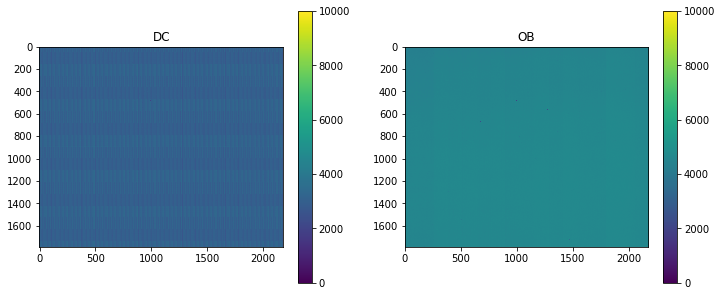

In [281]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(dc,vmax=10000,vmin=0)
plt.title('DC')
plt.colorbar()
plt.subplot(1,2,2)
ob2=ob1[450:500,975:1050]
plt.imshow(ob1,vmax=10000,vmin=0)
plt.title('OB')
plt.colorbar()

0.0 65535.0 4019.7090298152093


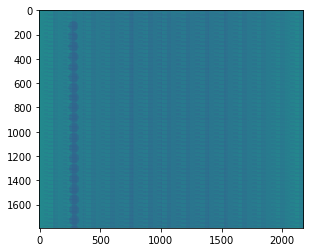

In [282]:
cal=loadStack(datapath+'xcal_{:05}.fits',1,361,10).astype(float)
print(cal.min(),cal.max(),cal.mean())
plt.imshow(cal[:,:,1],vmin=0.0,vmax=10000)

In [283]:
def normalizeData(img,ob,dc) :
    for idx in np.arange(0, cal.shape[2]):
        tmp=(img[:,:,idx]-dc)
        tmp[tmp<=0]=1
        img[:,:,idx]=(tmp/ob1)
    lcal=-np.log(img)
    
    return lcal

In [284]:
lcal=normalizeData(cal,ob,dc)

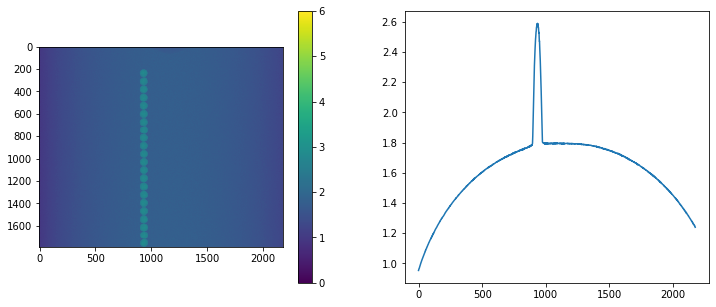

In [285]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[:,:,idx],vmin=0,vmax=6)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[:,:,idx].mean(axis=0))


In [286]:
def removeBaseline(img) :
    baseline = lcal.mean(axis=2).mean(axis=0)
    baseline=baseline.reshape(1,baseline.shape[0])

    b2=np.matmul(np.ones([lcal.shape[0],1]),baseline)
    res=img;
    for idx in np.arange(0,img.shape[2]) :
        res[:,:,idx]=res[:,:,idx]-b2
    return res

In [287]:
bcal=removeBaseline(lcal)

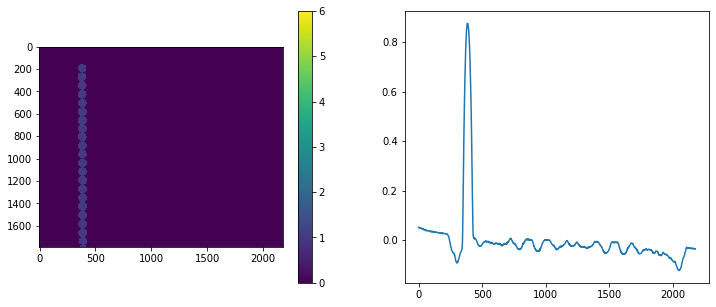

In [288]:
idx=5
m = bcal.mean()
s = bcal.std()
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(m+1.96*s < bcal[:,:,idx],vmin=0,vmax=6)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(bcal[:,:,idx].mean(axis=0))

In [289]:
def thresholdBBs(img,k) :
    s=bcal.std()
    m=bcal.mean()
    
    return (m+k*s)< img


In [290]:
tcal=thresholdBBs(bcal,1.0)

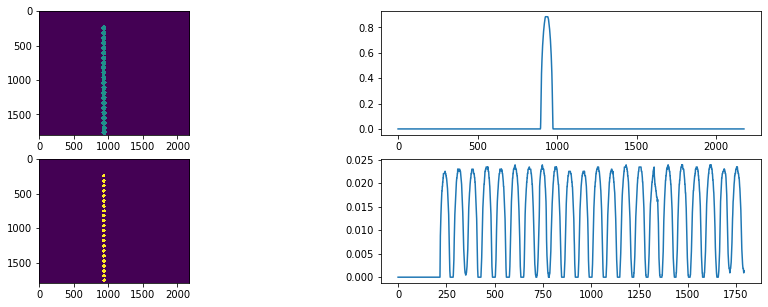

In [291]:
idx=10
fig,ax = plt.subplots(2,2,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(tcal[:,:,idx],vmin=0,vmax=2)
ax[1].plot(tcal[:,:,idx].mean(axis=0))
ecal = erode(tcal[:,:,idx],disk(12))
ax[2].imshow(ecal)
ax[3].plot(ecal.mean(axis=1))

In [292]:
def findBeadsWS(img) :
    distance = ndi.distance_transform_edt(img)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9)),labels=img)
    markers = ndi.label(local_maxi)[0]

    labels = watershed(-distance, markers, mask=img)

    h,ax=np.histogram(labels,bins=np.arange(0,labels.max()+1))
    m=h[np.argwhere(h<0.05*np.prod(labels.shape))].mean()
    s=h[np.argwhere(h<0.05*np.prod(labels.shape))].std()
    cog=[]
    for i in np.arange(0, h.size) :
        if ((m-s)<h[i]) and (h[i]<(m+s)) :
            selection=np.argwhere(labels==i)
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog




In [293]:
def findBeads(img, selem, c = 1.96) :
    eimg = erode(img,selem)
     
    labels = label(eimg)
    ll = {}
    for i in np.arange(0, labels.max()+1) :
        a = np.sum(labels==i)
        if (a<np.prod(img.shape)/2) :
            ll[i]=a
    
    m = np.mean(list(ll.values()))
    s = np.std(list(ll.values()))
  #  print(m,s)
    
    cog=[]
    for lbl in ll :
        selection=np.argwhere(labels==lbl)
        if ((len(selection)<m+c*s) and (m-c*s<len(selection))) :
       #     print(len(selection))
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog

In [294]:
idx=10
cog=findBeads(tcal[:,:,idx],disk(15),c=1.96)

In [295]:
cog.shape

(21, 2)

In [296]:
def buildBeadList(img,selem=disk(12),c=1.96) :
    beadlist = []

    for idx in np.arange(0, img.shape[2]) :
        cog=findBeads(img[:,:,idx],selem,c)
        beadlist.append(cog)

    return beadlist

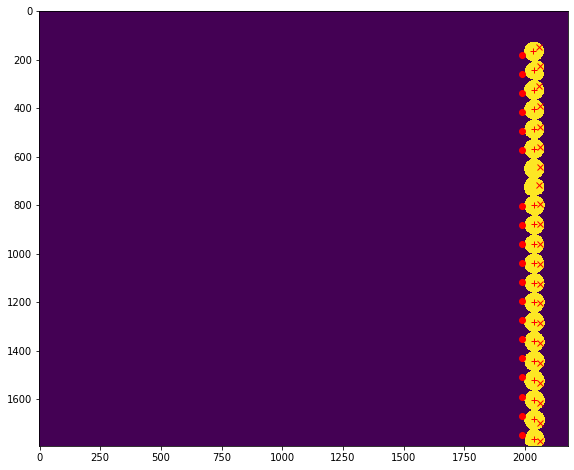

In [297]:
idx=20
c=2.5
cog=findBeads(tcal[:,:,idx],disk(15),c=c)

plt.figure(figsize=[12,8])
plt.imshow(tcal[:,:,idx])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeads(tcal[:,:,idx+1],disk(15),c=c)
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeads(tcal[:,:,idx-1],disk(15),c=c)
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

In [298]:
cog

array([[ 165.73251232, 2036.13399015],
       [ 244.84481904, 2040.38274665],
       [ 324.81984948, 2036.36923801],
       [ 405.89601076, 2036.87494397],
       [ 486.80744186, 2037.6344186 ],
       [ 567.61548614, 2036.78574571],
       [ 800.12461606, 2037.91443616],
       [ 880.20211742, 2037.77622714],
       [ 959.83830606, 2037.36236766],
       [1039.46143498, 2037.0161435 ],
       [1119.84740883, 2038.25767754],
       [1199.70506713, 2037.52533564],
       [1281.07045952, 2037.76805252],
       [1361.38649489, 2037.80275433],
       [1441.16746204, 2037.80520607],
       [1522.69753354, 2037.97273907],
       [1602.91238012, 2038.33653008],
       [1683.80777446, 2038.33660829],
       [1763.62556664, 2039.03399819]])

In [299]:
def medianDistance(cog) :
    return np.median(np.diff(cog[:,0]))

def itemList(cog) :
    d=medianDistance(cog)
    idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
    idxList={}
    for (i,c) in zip(idx,cog) :
        idxList[i]=c
        
    return idxList

def pruneEllipse(e) :
    pe = 1
    
def identifyEllipses(img,selem,c) :
    N=img.shape[2]
    ellipses = {}
    for proj in np.arange(0,N) :
        cog = findBeads(img[:,:,proj],selem=selem,c=c)
        cogIdx = itemList(cog)
        for idx in cogIdx :
            if idx in ellipses :
                ellipses[idx] = np.vstack([ellipses[idx], cogIdx[idx]])
            else :
                ellipses[idx] = cogIdx[idx]

    
    return ellipses

    

In [300]:
e=identifyEllipses(tcal[:,:,0:23],disk(15),c=2.5)

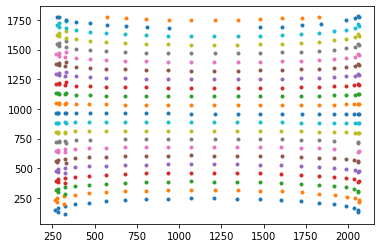

In [327]:
for idx in np.arange(0,len(e)) :
    plt.plot(e[idx][:,1],e[idx][:,0],'.')

In [302]:
def rearrangeCOG(coglist,N) :

    res=coglist[0][0:N,:]
    
    for idx in np.arange(0,len(coglist)-1) :
        res=np.append(res,coglist[idx][0:N,:],axis=0)
        
    return res


In [303]:
r=rearrangeCOG(beadlist,16)
print(r.shape,len(beadlist),r.shape[0]/len(beadlist))


(488, 2) 37 13.18918918918919


In [304]:
def sphereMetrics(h,pixSize) :
    hs=np.sort(h)
    A=hs[3:-3].mean()
    R=np.sqrt(A/np.pi)
    D=2*R*pixSize
    print("Diameter=",D,"mm")
    
    return D

# Estimate ellipse

$\dfrac {((X-C_x)\cos(\theta)+(Y-C_y)\sin(\theta))^2}{(R_x)^2}+\dfrac{((X-C_x) \sin(\theta)-(Y-C_y) \cos(\theta))^2}{(R_y)^2}=1$

There:
- (𝐶𝑥,𝐶𝑦) is the center of the Ellipse.
- 𝑅𝑥 is the Major-Radius, and 𝑅𝑦 is the Minor-Radius.
- 𝜃 is the angle of the Ellipse rotation.

In [307]:
from skimage.measure import EllipseModel 

## Testing skimage ellipse

[9.999999999999718, 15.000000000000078, 4.0000000000015365, 7.999999999996195, 0.5235987755982433] 30.000000000059085


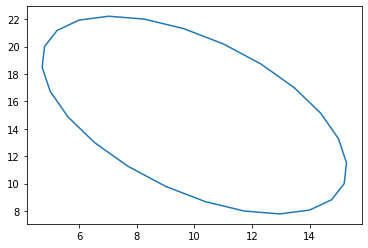

In [308]:
xy = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25),params=(10, 15, 4, 8, np.deg2rad(30)))
ellipse = EllipseModel()
ellipse.estimate(xy)
print(ellipse.params, np.rad2deg(0.5235987755993301))
plt.plot(xy[:,0],xy[:,1])

# Estimating bead ellipses

In [309]:
def estEllipses(coords):
    pars={}
    ellipse = EllipseModel()
    
    for idx in coords :
        ellipse.estimate(coords[idx])
        if ellipse.params[3] < ellipse.params[2] :
            (ellipse.params[3],ellipse.params[2]) = (ellipse.params[2],ellipse.params[3])
        pars[idx]=ellipse.params
        
    return pars
        

In [310]:
pars=estEllipses(e)

In [311]:
pars[0]

[145.12704443310145,
 1165.3316083752425,
 99.34382404203718,
 897.3575399995071,
 1.5746799640565854]

## Plot estimated parameters

In [312]:
del pars[10]
del pars[21]

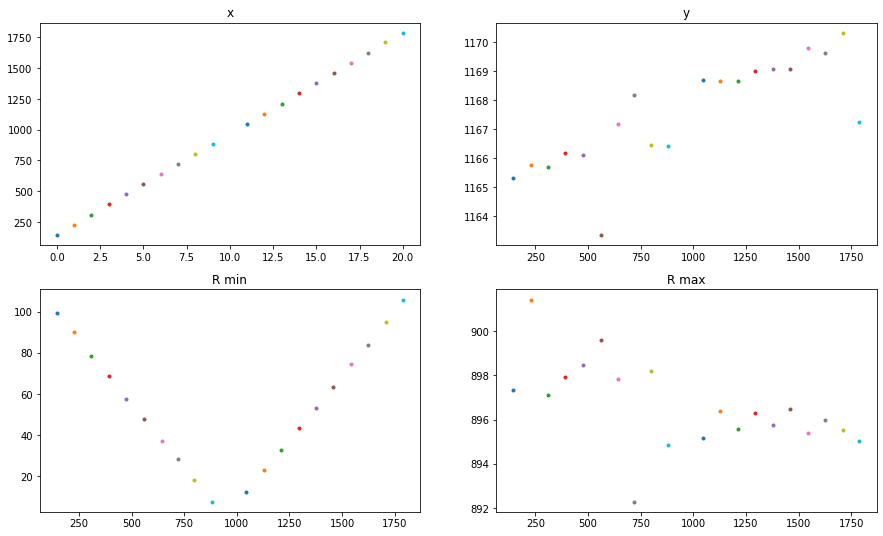

In [313]:
fig,ax = plt.subplots(2,2,figsize=[15,9])
ax=ax.ravel()
for pidx in pars :
    ax[0].plot(pidx,pars[pidx][0],'.')
    ax[0].set_title('x')
    ax[1].plot(pars[pidx][0],pars[pidx][1],'.')
    ax[1].set_title('y')


    ax[2].plot(pars[pidx][0],pars[pidx][2],'.')
    ax[2].set_title('R min')
    ax[3].plot(pars[pidx][0],pars[pidx][3],'.')

    ax[3].set_title('R max')


## Estimate SOD and SDD
Use the projected bead sizes of front and back side plus their distances from the rotation center.

In [334]:
def findMinRadius(pars, split) :
    x = []
    r = []
    
    for idx in pars :
        x.append(pars[idx][0])
        r.append(pars[idx][2])
    x = np.array(x)
    r = np.array(r)

    fit0 = np.polyfit(x[0:split], r[0:split], 1, full=True)
    fit1 = np.polyfit(x[split:], r[split:], 1, full=True)

    f0=fit0[0]
    f1=fit1[0]
    return (f1[1]-f0[1])/(f0[0]-f1[0])

In [335]:
vpiercing=findMinRadius(pars,10)
print('Vertical piercing point at {:0.2f}'.format(vpiercing))

Vertical piercing point at 944.71


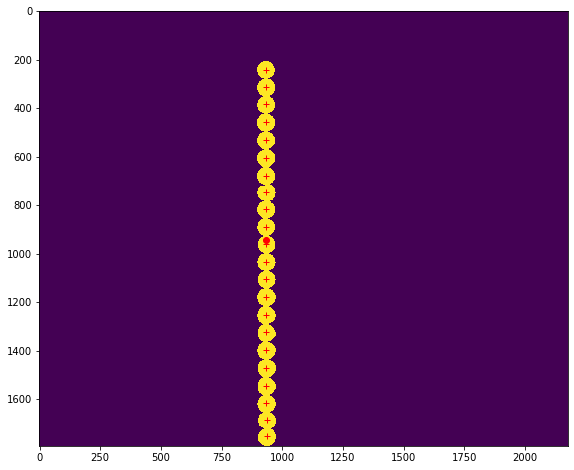

In [346]:
idx=10
c=2.5
cog=findBeads(tcal[:,:,idx],disk(15),c=c)

plt.figure(figsize=[12,8])
plt.imshow(tcal[:,:,idx])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')
plt.plot(cog[10,1]-1,vpiercing,'ro')

In [338]:
def sampleTilt(pars) :
    x = []
    y = []
    
    for idx in pars :
        x.append(pars[idx][1])
        y.append(pars[idx][0])
    x = np.array(x)
    y = np.array(y)
    
    fit0 = np.polyfit(x, y, 1, full=True)
    print(fit0[0])
    return 90-np.arctan(fit0[0][0])*180/np.pi

In [339]:
print('Sample tilt = {:0.2f} degrees'.format(sampleTilt(pars)))

[ 2.30333645e+02 -2.67958881e+05]
Sample tilt = 0.25 degrees


<img src="CBCTGeometry.svg">
<img src="CBCT_sample.jpg" style="height:200px">

r=10mm
pixel size = 0.139mm

$\mbox{magnification}=\frac{SDD}{SOD} = \frac{h_a}{}$

In [314]:
magn = medianDistance(cog)*0.139
print("The magnification is {:0.2f}".format(magn))

The magnification is 11.16


In [323]:
def estDistances(h,ha,hb,R) :
    H = np.array([[1,-h/ha], [1,-h/hb]])
    y = np.array([-R,R])
        
    est=np.linalg.solve(H,y)
    
    return est

In [382]:
pixelSize = 0.139
R = 10
c0=itemList(findBeads(tcal[:,:,0],selem=disk(15),c=2.5))
sod = []
sdd = [] 
for idx in pars :
    ha=(pars[idx][0]-pars[idx][2]-vpiercing) * pixelSize
    hb=(pars[idx][0]+pars[idx][2]-vpiercing) * pixelSize
    #h=(idx-9.239)
    if idx in c0 :
        h = (c0[idx][0]-vpiercing)*pixelSize/11.82+0.5
        est = estDistances(h,ha,hb,R)
        sod.append(np.abs(est[0]))
        sdd.append(np.abs(est[1]))
        print("h: {0:0.3f}, SDD: {1:0.2f}, {2:0.2f}, magn: {3:0.2f}".format(h,est[0], est[1],est[1]/est[0]))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print(sod,sdd, sdd/sod)

h: -9.271, SDD: -80.49, -950.00, magn: 11.80
h: -8.260, SDD: -79.68, -947.14, magn: 11.89
h: -7.262, SDD: -81.03, -970.88, magn: 11.98
h: -6.245, SDD: -80.46, -974.17, magn: 12.11
h: -5.219, SDD: -81.19, -998.40, magn: 12.30
h: -4.221, SDD: -80.90, -1011.85, magn: 12.51
h: -3.170, SDD: -80.89, -1052.98, magn: 13.02
h: -2.214, SDD: -78.46, -1089.18, magn: 13.88
h: -1.268, SDD: -80.92, -1278.79, magn: 15.80
h: -0.254, SDD: -83.16, -2865.13, magn: 34.45
h: 1.757, SDD: 80.53, 628.97, magn: 7.81
h: 2.773, SDD: 79.49, 717.81, magn: 9.03
h: 3.783, SDD: 80.47, 772.48, magn: 9.60
h: 4.814, SDD: 80.15, 796.01, magn: 9.93
h: 5.822, SDD: 80.91, 821.35, magn: 10.15
h: 6.836, SDD: 81.30, 836.93, magn: 10.29
h: 7.860, SDD: 80.30, 836.08, magn: 10.41
h: 8.877, SDD: 81.33, 853.57, magn: 10.49
h: 9.903, SDD: 80.36, 848.81, magn: 10.56
80.63226982360679 1013.186449042138 12.565520619208792


In [368]:
c0

{0: array([113.83859369, 324.2253296 ]),
 1: array([199.75321443, 320.15968478]),
 2: array([284.69655694, 325.01513432]),
 3: array([371.14875136, 325.07274701]),
 4: array([458.3722075 , 324.77054146]),
 5: array([543.28448666, 330.48801447]),
 6: array([632.6572973 , 326.62738739]),
 7: array([713.95023885, 328.45023885]),
 8: array([794.34879603, 326.85764873]),
 9: array([880.63184664, 327.26799687]),
 10: array([966.24479371, 328.0762279 ]),
 11: array([1051.62930403,  329.19230769]),
 12: array([1137.97967956,  328.40992575]),
 13: array([1223.85527709,  329.67702083]),
 14: array([1311.52538787,  330.03667137]),
 15: array([1397.24194133,  330.64795364]),
 16: array([1483.45444953,  331.32395357]),
 17: array([1570.5903146 ,  331.33050548]),
 18: array([1657.07303171,  331.48272177]),
 19: array([1744.26593179,  332.18877024])}

In [373]:
for q in c0 :
    print((c0[q][0]-vpiercing)*pixelSize/12.5)

-9.239266924206337
-8.283896341507814
-7.339326372807477
-6.377977970919879
-5.408053138643749
-4.463828594379424
-3.470002940066223
-2.5660254299612144
-1.6719934741141527
-0.7125259514268794
0.23949002007820439
1.1889657747936913
2.14918195072093
3.10411859524445
4.079010227104897
5.032178301528577
5.990861392707496
6.959812212326467
7.9215000265635345
8.891085075544844
